In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from scipy.special import gammainc 
from scipy.special import gamma

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize=18
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]


_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)



In [3]:
def f_lambda(l):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.))))

f_lambda = np.vectorize(f_lambda)


def T_at_z0_from_T_at_zinf(T_tilde,l,Omega_dcdm_ini):
    return T_tilde*(1.+1.922e4*Omega_dcdm_ini*f_lambda(l))**0.25

def T_at_zinf_from_T_at_z0(T,l,Omega_dcdm_ini):
    return T*(1-1.922e4*Omega_dcdm_ini*f_lambda(l))**0.25

def Gamma_of_lambda(l,Om,h):
    return l*Om**0.5*100.*h



In [4]:
omega_dcdm_in = 1e-3
h = 0.69
Omega_dcdm_ini = omega_dcdm_in/h/h
Gamma = 10**4.5
H0 = 100*h
Omega_m =0.3
l = Gamma/H0/Omega_m**0.5
T = 2.72548
T_at_zinf_from_T_at_z0(T,l,Omega_dcdm_ini)

2.2472448868586357

In [5]:
Gamma

31622.776601683792

Text(0.5, 0, '$\\lambda$')

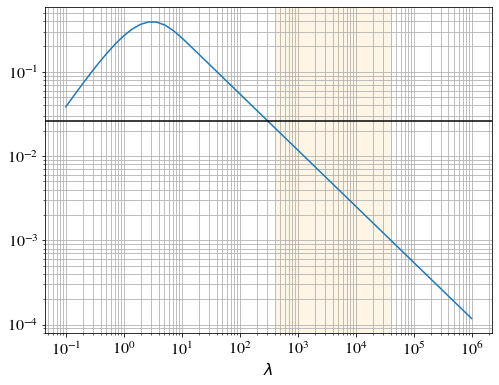

In [6]:
l = np.geomspace(1e-1,1e6)
a_f_lambda = f_lambda(l)
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(l,a_f_lambda,label=r'$f(\lambda)$')
c = 0.5/1.922e4
Om_dcdm_ini = 1e-3
ax.axhline(c/Om_dcdm_ini,c='k',label=r'$\Omega_{dcdm,ini}=10^{-3}$')
ax.axvspan(4e2,4e4,alpha=0.1,color='orange')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel(r'$\lambda$')
# plt.ylabel(r'$f(\lambda)$')

In [7]:
lambda_p = 1e4
Gamma_p = Gamma_of_lambda(lambda_p,0.3,0.7)
Gamma_p

383405.79025361623

In [8]:
gamma_vals = [20000.,80000.,200000.]
Tcmb_vals = np.linspace(2.65,2.85,10)
opzs = []
Ts = []
hs = []
ls = []
cls = []

In [9]:
Omega_cdm = 0.25
Om_dcdm_ini =  1e-4
opzs = []
Ts = []
hs = []
ls = []
cls = []
for Tcmb_tilde in Tcmb_vals:
    print(Tcmb_tilde)
    Gamma_p = gamma_vals[2]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk',
                        '100*theta_s':1.04119,
                        'omega_b_hat':0.022032,
                        'omega_cdm_hat': 0.119,
                        'omega_ini_dcdm_hat':0.001,
                        'Gamma_dcdm':Gamma_dcdm,

                        'logA_hat' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb':  Tcmb_tilde,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
#     try:
    # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
    M_dr_is_sr.compute()
    print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
    z = M_dr_is_sr.get_background()['z']
    rho_g = M_dr_is_sr.get_background()['(.)rho_g']
    T_cmb = M_dr_is_sr.T_cmb()


    h = M_dr_is_sr.h()
    H0_class = h*100*1e3/_c_
    rho_crit0_class = H0_class**2

    Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
    rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
    T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
    T_cmb_eff_class =  M_dr_is_sr.T_cmb_dcdmsr()
    print("T_cmb_eff_class = %.3e"%(T_cmb_eff_class))

    opzs.append(1+z)
    Ts.append(T_cmb_eff)
    hs.append(h)
    ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
    cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

#     except:
#         print("compute failed")
#         continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

2.65
H0 = 7.045e+01
T_cmb_eff_class = 2.753e+00
2.672222222222222
H0 = 6.979e+01
T_cmb_eff_class = 2.776e+00
2.694444444444444
H0 = 6.913e+01
T_cmb_eff_class = 2.799e+00
2.716666666666667
H0 = 6.846e+01
T_cmb_eff_class = 2.822e+00
2.738888888888889
H0 = 6.780e+01
T_cmb_eff_class = 2.846e+00
2.761111111111111
H0 = 6.714e+01
T_cmb_eff_class = 2.869e+00
2.783333333333333
H0 = 6.647e+01
T_cmb_eff_class = 2.892e+00
2.8055555555555554
H0 = 6.581e+01
T_cmb_eff_class = 2.915e+00
2.827777777777778
H0 = 6.515e+01
T_cmb_eff_class = 2.938e+00
2.85
H0 = 6.448e+01
T_cmb_eff_class = 2.961e+00


0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

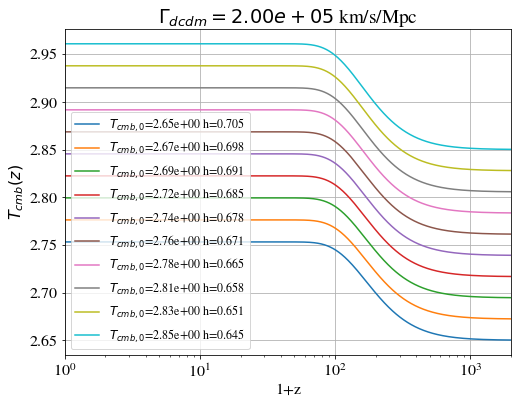

In [10]:
# for Tcmb_tilde in Tcmb_vals:
for (i,Tcmb_tilde) in enumerate(Tcmb_vals):
    print(i)
    plt.plot(opzs[i],Ts[i],
                   label=r"$T_{cmb,0}$=%.2e h=%.3f"%(Tcmb_tilde,hs[i]))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

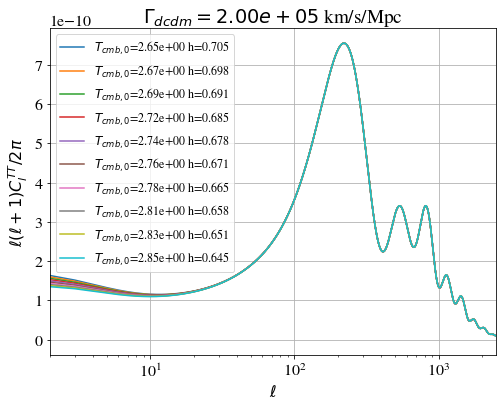

In [11]:
for (i,Tcmb_tilde) in enumerate(Tcmb_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$T_{cmb,0}$=%.2e h=%.3f"%(Tcmb_tilde,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [12]:
gamma_vals = [20000.,80000.,200000.]
Om_dcdm_ini_vals = np.geomspace(1e-5,1e-3,10)
opzs = []
Ts = []
hs = []
ls = []
cls = []

In [25]:
Omega_cdm = 0.25
opzs = []
Ts = []
hs = []
ls = []
cls = []
for Om_dcdm_ini in Om_dcdm_ini_vals:
    print(Om_dcdm_ini)
    Gamma_p = gamma_vals[2]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk',
                        '100*theta_s':1.04119,
#                         'omega_b':0.022032,
#                         'omega_cdm': 0.119,
#                         'Omega_ini_dcdm':Omega_ini_dcdm,
#                         'Gamma_dcdm':Gamma_dcdm,
                        'omega_b':0.022032,
                        'Omega_cdm': Omega_cdm,
                        'Omega_ini_dcdm': Omega_ini_dcdm,
                        'Gamma_dcdm':Gamma_dcdm,
                        'ln10^{10}A_s' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb_dcdmsr':  2.725e+0,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()


        h = M_dr_is_sr.h()
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        
        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

    except:
        print("compute failed")
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

1e-05
H0 = 6.843e+01
1.6681005372000593e-05
H0 = 6.843e+01
2.782559402207126e-05
H0 = 6.843e+01
4.641588833612782e-05
H0 = 6.844e+01
7.742636826811278e-05
H0 = 6.844e+01
0.0001291549665014884
H0 = 6.845e+01
0.00021544346900318823
H0 = 6.847e+01
0.00035938136638046257
H0 = 6.850e+01
0.0005994842503189409
H0 = 6.856e+01
0.001
H0 = 6.868e+01


0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

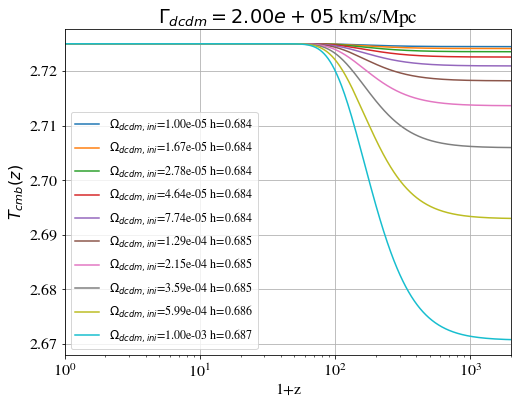

In [26]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    try:
        plt.plot(opzs[i],Ts[i],
                       label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
    except:
        print('failed at'+str(i))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

(1.0, 2000.0)

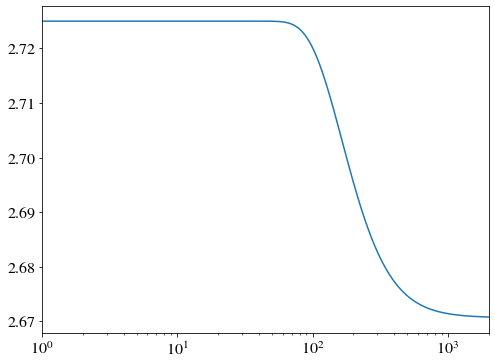

In [27]:
plt.plot(opzs[0],np.vectorize(M_dr_is_sr.modified_T_cmb)(opzs[0]-1.))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+05$ km/s/Mpc')

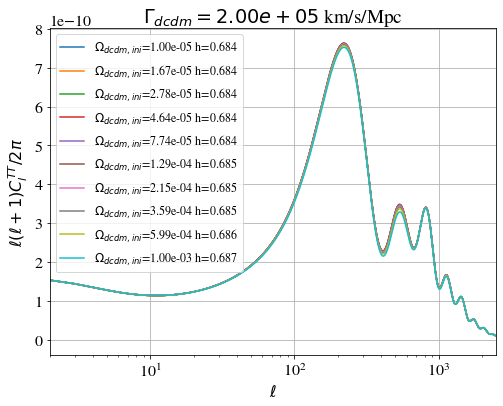

In [28]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [97]:
Omega_ini_dcdm = 0.000205
Gamma_dcdm = 1000.

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                  'Omega_cdm': 0.25,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    #'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



In [98]:
M_dr_is_sr.Omega0_m()

0.29639067468754654

In [99]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

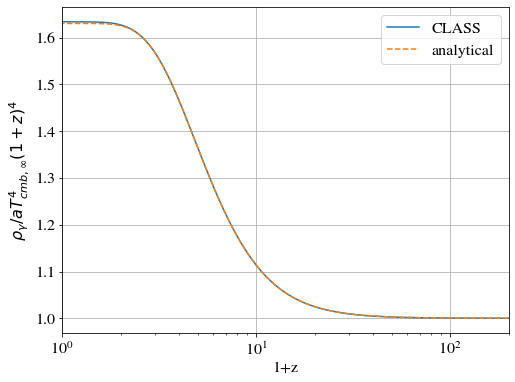

In [100]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [24]:
Omega_cdm = 0.25
opzs = []
Ts = []
hs = []
ls = []
cls = []
for Om_dcdm_ini in Om_dcdm_ini_vals:
    print(Om_dcdm_ini)
    Gamma_p = gamma_vals[0]
    Gamma_dcdm = Gamma_p
    Omega_ini_dcdm = Om_dcdm_ini
    common_settings_dcdm_syn_dr_is_sr = {
                        'output':'tCl,mTk,vTk',
                        '100*theta_s':1.04119,
                        'omega_b':0.022032,
                        'Omega_cdm': Omega_cdm,
                        'Omega_ini_dcdm': Omega_ini_dcdm,
                        'Gamma_dcdm':Gamma_dcdm,

                        'ln10^{10}A_s' : 3.0980,
                        'tau_reio':0.0925,
                        'gauge' : 'synchronous',
                        'dr_is_sr': 1,
                        'T_cmb_dcdmsr':  2.725e+0,
    }

    M_dr_is_sr = Class()
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    try:
        # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
        M_dr_is_sr.compute()
        print("H0 = %.3e"%(100.*M_dr_is_sr.h()))
        z = M_dr_is_sr.get_background()['z']
        rho_g = M_dr_is_sr.get_background()['(.)rho_g']
        T_cmb = M_dr_is_sr.T_cmb()


        h = M_dr_is_sr.h()
        H0_class = h*100*1e3/_c_
        rho_crit0_class = H0_class**2

        Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
        rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
        T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
        
        opzs.append(1+z)
        Ts.append(T_cmb_eff)
        hs.append(h)
        ls.append(M_dr_is_sr.raw_cl(2500)['ell'])
        cls.append(M_dr_is_sr.raw_cl(2500)['tt'])
#         plt.plot(1+z,T_cmb_eff*(1.+z)**0,
#                    label='T_cmb dcdm->sr')
#         plt.plot(1+z,T_cmb*(1.+z)**0,
#                    label='T_cmb lcdm')

    except:
        print("compute failed")
        continue

# plt.xscale('log')
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
# # plt.ylim(1e0,5)
# plt.legend()
# plt.xlabel('1+z')
# plt.ylabel(r'$T_{cmb}(z)$')

1e-05
H0 = 6.843e+01
1.6681005372000593e-05
H0 = 6.843e+01
2.782559402207126e-05
H0 = 6.844e+01
4.641588833612782e-05
H0 = 6.845e+01
7.742636826811278e-05
H0 = 6.847e+01
0.0001291549665014884
H0 = 6.851e+01
0.00021544346900318823
H0 = 6.858e+01
0.00035938136638046257
H0 = 6.875e+01
0.0005994842503189409
H0 = 6.919e+01
0.001
H0 = 7.089e+01


In [25]:
hs

[0.6843105,
 0.6843453,
 0.6844046,
 0.6845092,
 0.6846985,
 0.6850589,
 0.685798,
 0.6874693,
 0.6919237,
 0.7088907]

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+04$ km/s/Mpc')

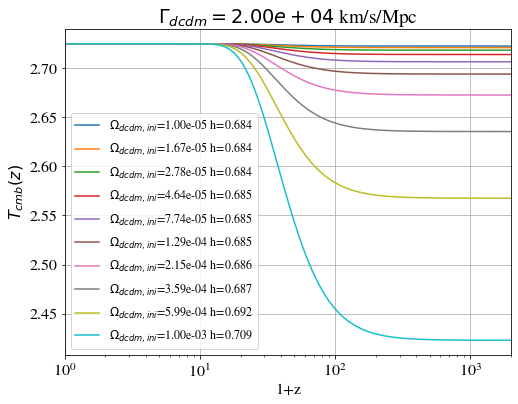

In [26]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(opzs[i],Ts[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.legend(fontsize=12)
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')
plt.grid()
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$\\Gamma_{dcdm}=2.00e+04$ km/s/Mpc')

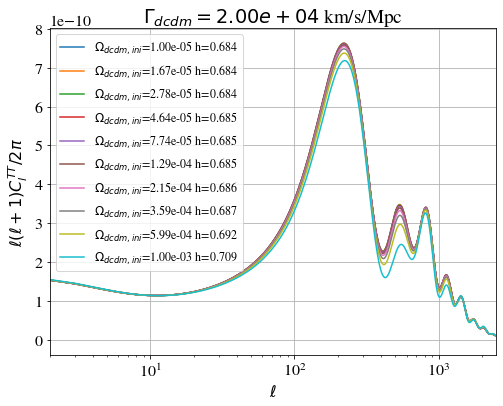

In [27]:
for (i,Om_dcdm_ini) in enumerate(Om_dcdm_ini_vals):
    print(i)
    plt.plot(ls[i],ls[i]*(ls[i]+1.)/2./np.pi*cls[i],
                   label=r"$\Omega_{dcdm,ini}$=%.2e h=%.3f"%(Om_dcdm_ini,hs[i]))
plt.xscale('log')
plt.legend()
# plt.yscale('linear')
# plt.xlim(1e0,2e3)
plt.xlim([2,2500])
# plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi $")
plt.grid()
plt.legend(fontsize=12)
plt.title(r"$\Gamma_{dcdm}=%.2e$ km/s/Mpc"%Gamma_p)

In [146]:
Omega_cdm = 0.25
Om_dcdm_ini = 1e-3
Gamma_p = 200000
Gamma_dcdm = Gamma_p
Omega_ini_dcdm = Om_dcdm_ini
common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                    'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                    'omega_b':0.022032,
                    'Omega_cdm': Omega_cdm,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                    'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
                    'T_cmb_dcdmsr':  2.725e+0,
    #'k_output_values' : k_list,
    
    #'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()

"H0 = %.3e"%(100.*M_dr_is_sr.h())

'H0 = 6.868e+01'

In [203]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':Omega_cdm,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    #'k_output_values' : k_list,
    'T_cmb': 2.525
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()

"H0 = %.3e  km/s/mpc"%(100.*M_lcdm.h())

'H0 = 6.950e+01  km/s/mpc'

Text(0, 0.5, '$T_{cmb}(z)$')

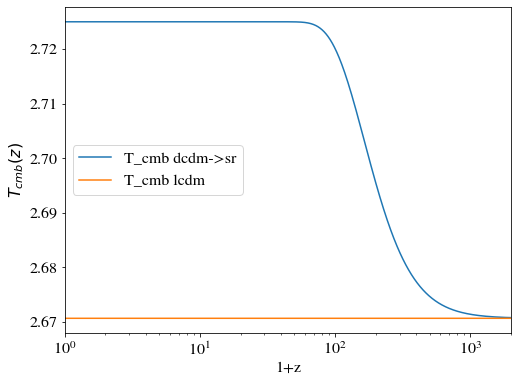

In [204]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()


h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
plt.plot(1+z,T_cmb_eff*(1.+z)**0,
           label='T_cmb dcdm->sr')
plt.plot(1+z,T_cmb*(1.+z)**0,
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
# plt.ylim(1e0,5)
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')

In [205]:

cls = M_dr_is_sr.raw_cl(2500)
cls_lcdm = M_lcdm.raw_cl(2500)

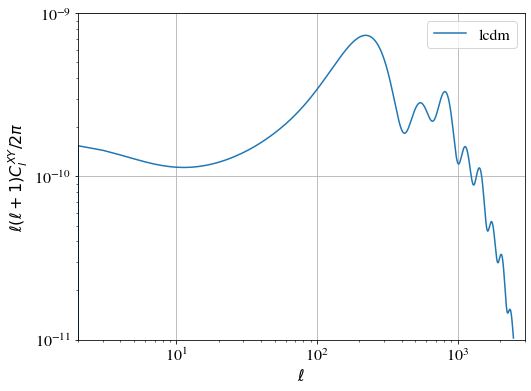

In [207]:
# l = cls['ell']
# plt.plot(cls['ell'],l*(l+1.)/2./np.pi*cls['tt'],label='dcdm->sr')
l = cls_lcdm['ell']
plt.plot(cls_lcdm['ell'],l*(l+1.)/2./np.pi*cls_lcdm['tt'],label='lcdm')
plt.loglog()
plt.legend()
plt.xlim([2,3000])
plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()

In [74]:
M_lcdm.struct_cleanup()
M_lcdm.empty()

M_dr_is_sr.struct_cleanup()
M_dr_is_sr.empty()

Text(0, 0.5, '$\\Omega(z)$')

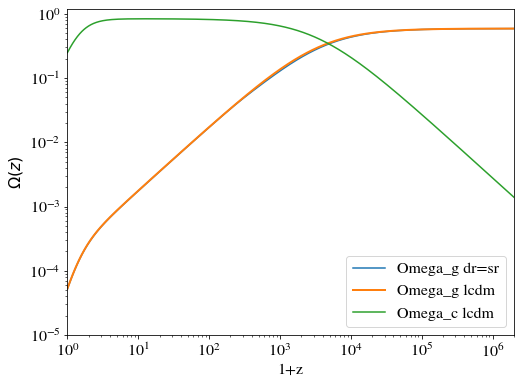

In [59]:
plt.loglog(1.+M_dr_is_sr.get_background()['z'],M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'],
           label='Omega_g dr=sr')


plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_g']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_g lcdm',lw=2)
plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_cdm']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_c lcdm')



# plt.loglog(1.+M_lcdm.get_background()['z'],Omega0_g_lcdm*(1.+M_lcdm.get_background()['z']))

# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'],label='Omega_dcdm')
# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'],label='Omega_dr')
# plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_g']/M_dr.get_background()['(.)rho_crit'],ls='--',label='Omega_g dr')


plt.legend(loc=4)
plt.xlim(1e0,2.e6)
plt.ylim(1e-5,1.2)
plt.xlabel('1+z')
plt.ylabel(r'$\Omega(z)$')

In [3]:
Gamma_dcdm = 0.1
k_list = '0.0001,0.001,0.01,0.1'
k_list_d = [float(k) for k in k_list.split(',')]



In [4]:
Omega_dm_tot = 0.25
f_dm_decay = 0.01
Gamma_dcdm = 2000.

In [5]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':Omega_dm_tot,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    'k_output_values' : k_list,
    'T_cmb': 2.725
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   #'Omega_cdm': (1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
    
    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}



M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()


M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()


_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
T_cmb = M_dr_is_sr.T_cmb()
h =  M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

In [6]:
common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   #'Omega_cdm': (1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                    
                   #'Omega_dm_tot': Omega_dm_tot,
                   #'f_dm_decay': f_dm_decay,
    
    'Omega_cdm':Omega_dm_tot,
    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

In [35]:
T_cmb_a = np.linspace(1.8,3.,30)

In [60]:
T_cmb_dcdmsr = []
for T_cmb in T_cmb_a :
    M_dr_is_sr = Class()
    common_settings_dcdm_syn_dr_is_sr['T_cmb'] = T_cmb
    common_settings_dcdm_syn_dr_is_sr['f_dm_decay'] = 0.5
    common_settings_dcdm_syn_dr_is_sr['Gamma_dcdm'] = 1000.
    M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
    # M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
    M_dr_is_sr.compute()
    T_cmb_dcdmsr.append(M_dr_is_sr.T_cmb_dcdmsr())

CosmoComputationError: 

Error in Class: background_init(L:702) :condition (pba->shooting_failed == _TRUE_) is true; Shooting failed, try optimising input_get_guess(). Error message:

input_init(L:422) :error in fzero_Newton(input_try_unknown_parameters, x_inout, dxdF, unknown_parameters_size, 1e-4, 1e-6, &fzw, &fevals, errmsg);
=>fzero_Newton(L:1114) :error in func(x_inout, x_size, param, F0, error_message);
=>input_try_unknown_parameters(L:3812) :error in background_init(&pr,&ba);
=>background_init(L:747) :error in background_solve(ppr,pba);
=>background_solve(L:1740) :error in generic_integrator(background_derivs, tau_start, tau_end, pvecback_integration, &bpaw, ppr->tol_background_integration, ppr->smallest_allowed_variation, &gi);
=>generic_integrator(L:103) :error in rkqs(&x, h, eps, &hdid, &hnext, derivs, parameters_and_workspace_for_derivs, pgi);
=>rkqs(L:144) :error in rkck(*x,h,derivs,parameters_and_workspace_for_derivs,pgi);
=>rkck(L:200) :error in (*derivs)(x+0.6*h, pgi->ytemp, pgi->ak4, parameters_and_workspace_for_derivs, pgi->error_message);
=>background_derivs(L:2419) :error in background_functions(pba, y, pba->normal_info, pvecback);
=>background_functions(L:483) :condition (rho_crit <= 0.) is true; rho_crit = -1.329401e+04 instead of strictly positive

In [57]:
T_cmb_a

array([1.8       , 1.84137931, 1.88275862, 1.92413793, 1.96551724,
       2.00689655, 2.04827586, 2.08965517, 2.13103448, 2.17241379,
       2.2137931 , 2.25517241, 2.29655172, 2.33793103, 2.37931034,
       2.42068966, 2.46206897, 2.50344828, 2.54482759, 2.5862069 ,
       2.62758621, 2.66896552, 2.71034483, 2.75172414, 2.79310345,
       2.83448276, 2.87586207, 2.91724138, 2.95862069, 3.        ])

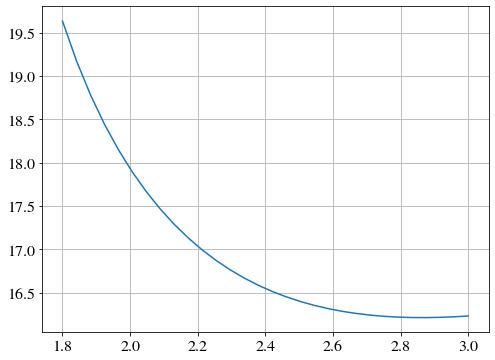

In [58]:
plt.plot(T_cmb_a,T_cmb_dcdmsr)
plt.grid()

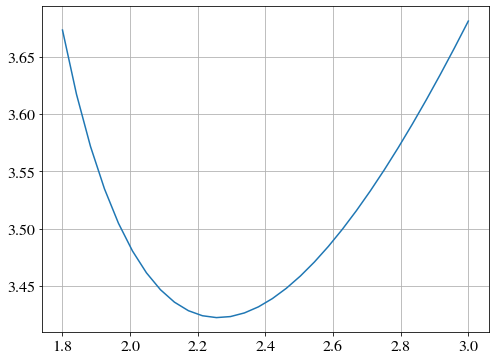

In [38]:
plt.plot(T_cmb_a,T_cmb_dcdmsr)
plt.grid()

In [6]:
f_dm_decay*Omega_dm_tot

0.0125

In [97]:
Omega_ini_dcdm = 0.000205
Gamma_dcdm = 1000.

common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                  'Omega_cdm': 0.25,#(1.-f_dm_decay)*Omega_dm_tot,
                   #'Omega_dcdmdr':f_dm_decay*Omega_dm_tot,
                  # 'Omega_dm_tot': Omega_dm_tot,
                  # 'f_dm_decay': f_dm_decay,
                   
                    'Omega_ini_dcdm': Omega_ini_dcdm,
                    'Gamma_dcdm':Gamma_dcdm,
                    
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'T_cmb': 2.6,
    #'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()



In [98]:
M_dr_is_sr.Omega0_m()

0.29639067468754654

In [99]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

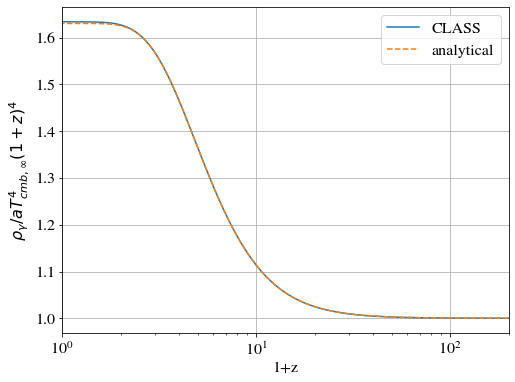

In [100]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

In [63]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

T_cmb_lcdm = 2.7
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb_lcdm,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

aR = Omega0_g_lcdm/T_cmb_lcdm**4.

In [64]:
def f_lambda(l):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.))))

f_lambda = np.vectorize(f_lambda)

Text(0.5, 0, '$\\lambda$')

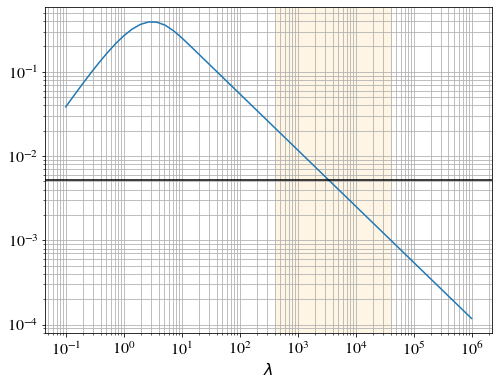

In [65]:
l = np.geomspace(1e-1,1e6)
a_f_lambda = f_lambda(l)
fig, ax = plt.subplots()
plt.plot(l,a_f_lambda,label=r'$f(\lambda)$')
c = 0.1/1.922e4
Om_dcdm_ini = 1e-3
ax.axhline(c/Om_dcdm_ini,c='k',label=r'$\Omega_{dcdm,ini}=10^{-3}$')
ax.axvspan(4e2,4e4,alpha=0.1,color='orange')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel(r'$\lambda$')
# plt.ylabel(r'$f(\lambda)$')

In [37]:
2000./_Mpc_over_km_

6.481558579328513e-17

In [36]:
_Mpc_over_m_ = 3.085677581282e22
_Mpc_over_km_ = 1e-3*_Mpc_over_m_
_c_ = 2.99792458e8 

In [38]:
H0 = 70 #km/s/Mpc
(H0/_Mpc_over_km_)

2.268545502764979e-18

In [39]:
G = 1.543e+04 #km/s/Mpc
(G/_Mpc_over_km_)

5.000522443951947e-16

In [40]:
 1.5e4/0.3**0.5/0.7/100.

391.2303982179759

In [41]:
1.5e6/0.3**0.5/0.7/100.

39123.03982179759

In [42]:
_Mpc_over_km_ = 1e-3*_Mpc_over_m_ 
Gamma_dcdm_min = 5e-16*_Mpc_over_km_
Gamma_dcdm_max = 5e-14*_Mpc_over_km_
"%.3e %.3e"%(Gamma_dcdm_min,Gamma_dcdm_max)

'1.543e+04 1.543e+06'

In [43]:
10**4.2

15848.93192461114

In [44]:
15848.93192461114/_Mpc_over_km_

5.136289034457844e-16

In [45]:
2.7e2*(5.136289034457844e-16/1e-14)**(2./3.)

37.3075503715745

In [46]:
def u_lambda_over_T4(Omega_ini_dcdm,l):
    return Omega_ini_dcdm/aR/2.725**4.*f_lambda(l)
    return Omega_ini_dcdm/aR/2.725**4.*f_lambda(l)
u_lambda_over_T4 = np.vectorize(u_lambda_over_T4) 

In [147]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

In [156]:
Z.shape

(160, 240)

Text(0.5, 1.0, 'Simplest default with labels')

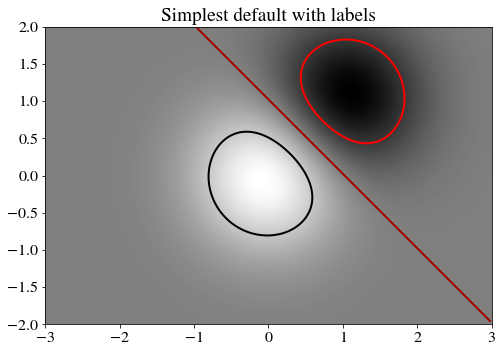

In [154]:
# fig, ax = plt.subplots()
import matplotlib.cm as cm
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear',
               origin='lower',
               cmap=cm.gray, extent=(-3, 3, -2, 2))
levels = [-1.,0.,1.]
CS = ax.contour(Z, levels, origin='lower', cmap='flag', extend='both',
                linewidths=2, extent=(-3, 3, -2, 2))
ax.set_title('Simplest default with labels')

In [144]:
"%.8e"%(1./aR/2.725**4.)

'1.92176677e+04'

In [136]:
Omega_ini_dcdm/Omega0_g_lcdm*T_cmb_lcdm**4.

111.26434249795733

In [127]:
M_dr_is_sr.h()

0.6891301

In [84]:
z=1e10
gammainc(5./3.,0.)

0.0

In [76]:
gamma(5./3.)
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l

53.305624315563904

In [83]:
 M_dr_is_sr.T_cmb()

2.6

In [84]:
h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power( M_dr_is_sr.T_cmb(),4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class

In [85]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
def fz(l,z):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+z)**(3./2.)))))
fz = np.vectorize(fz)

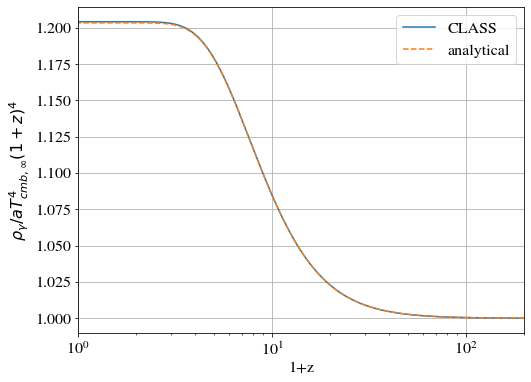

In [86]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']/rho_g_lcdm
plt.plot(1+z,rho_g,label='CLASS')
plt.plot(1+z,fz(l,z),ls='--',label='analytical')
plt.xscale('log')
plt.xlim(1,200)
# plt.ylim(0.98,1.25)
plt.xlabel('1+z')
plt.ylabel(r'$\rho_\gamma/aT_{cmb,\infty}^4(1+z)^4$')
plt.legend()
plt.grid()

Text(0, 0.5, '$T_{cmb}(z)$')

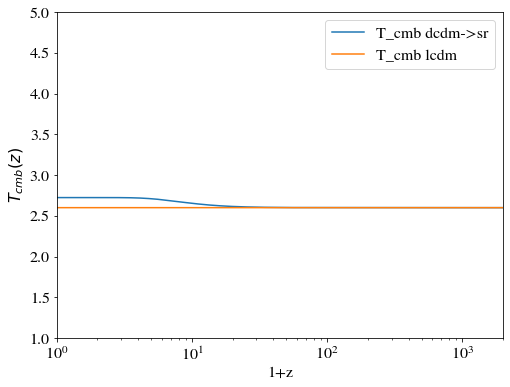

In [27]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
T_cmb = M_dr_is_sr.T_cmb()


h = M_dr_is_sr.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2

Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = M_dr_is_sr.T_cmb()*(rho_g/rho_g_lcdm)**0.25
plt.plot(1+z,T_cmb_eff*(1.+z)**0,
           label='T_cmb dcdm->sr')
plt.plot(1+z,T_cmb*(1.+z)**0,
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e3)
plt.ylim(1e0,5)
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$T_{cmb}(z)$')

Text(0, 0.5, '$\\Delta T_{cmb}/T_{cmb}(z)$')

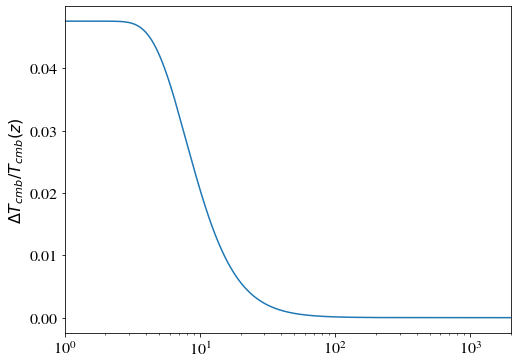

In [57]:
plt.plot(1+z,-(T_cmb-T_cmb_eff)/T_cmb,
           label='T_cmb dcdm->sr')
plt.xlim(1e0,2e3)
plt.xscale('log')
plt.yscale('linear')
plt.ylabel(r'$\Delta T_{cmb}/T_{cmb}(z)$')

In [99]:
-(T_cmb-T_cmb_eff)/T_cmb

array([-0.00000000e+00, -0.00000000e+00, -1.70803542e-16, ...,
        4.75272922e-02,  4.75272922e-02,  4.75273780e-02])

In [28]:
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

#a = Omega0_g_lcdm

In [54]:
from scipy.special import gammainc 
from scipy.special import gamma

In [56]:
gamma

<ufunc 'gamma'>

In [55]:
gamma(5./3.)

0.9027452929509338

In [49]:
b_over_a = Omega_ini_dcdm/Omega0_g_lcdm
b_over_a

19.953438679232555

In [119]:
def ftcmb(l):
    return (1.-1.1077)*l**(-2./3.)*gammainc(5./3.,2./3.*l)
ftcmb = np.vectorize(ftcmb)

def dT_T(l,b_over_a):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return (1.+b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.)))))**0.25-1.
dT_T = np.vectorize(dT_T)


def dT_T_taylor(l,b_over_a):
        #return 1.-(1.+1.18293*b_over_a*ftcmb(l))**0.25
        return 0.25*(b_over_a*(2.*l/3.)**(-2./3.)*(gamma(5./3.)-(gamma(5./3.)-gamma(5./3.)*gammainc(5./3.,2./3.*l/(1.+0.)**(3./2.)))))
dT_T_taylor = np.vectorize(dT_T_taylor)



In [120]:
l = np.geomspace(1e-2,1e4,100)
a_ftcmb = ftcmb(l) 
a_dT_T = dT_T(l,2.43) 
b_dT_T = dT_T(l,0.243) 
c_dT_T = dT_T(l,24.3) 

a_dT_T_taylor = dT_T_taylor(l,2.43) 
b_dT_T_taylor = dT_T_taylor(l,0.243) 
c_dT_T_taylor = dT_T_taylor(l,24.3) 

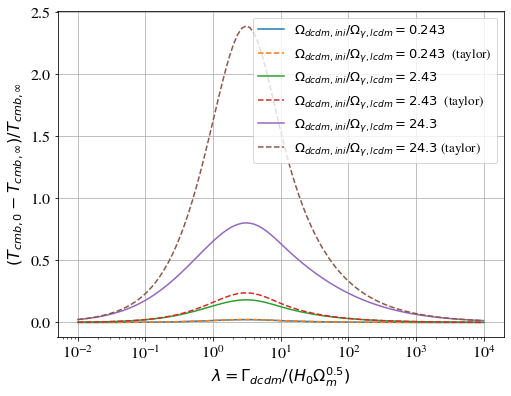

In [124]:

plt.plot(l,b_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=0.243$')
plt.plot(l,b_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=0.243$  (taylor)')
plt.plot(l,a_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=2.43$')
plt.plot(l,a_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=2.43$  (taylor)')
plt.plot(l,c_dT_T,label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=24.3$')
plt.plot(l,c_dT_T_taylor,ls='--',label=r'$\Omega_{dcdm,ini}/\Omega_{\gamma,lcdm}=24.3$ (taylor)')
plt.xscale('log')
plt.xlabel(r'$\lambda=\Gamma_{dcdm}/(H_0\Omega_m^{0.5})$')
plt.ylabel(r'$(T_{cmb,0}-T_{cmb,\infty})/T_{cmb,\infty}$')
plt.grid()
plt.legend(fontsize=13)

In [131]:
l0 = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l0
dT_T(l0,b_over_a)

array(0.04736293)

In [132]:
dT_T_taylor(l0,b_over_a)

array(0.05083531)

In [54]:
l = Gamma_dcdm/M_dr_is_sr.Omega0_m()**0.5/M_dr_is_sr.h()/100.
l

53.29246146035244

In [6]:
M_dr_is_sr.T_cmb_dcdmsr()

2.723571182729541

In [3]:
common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_cdm':0.25,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    #'k_output_values' : k_list,
    'T_cmb': 2.725
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()

In [7]:

cls = M_dr_is_sr.raw_cl(2500)
cls_lcdm = M_lcdm.raw_cl(2500)

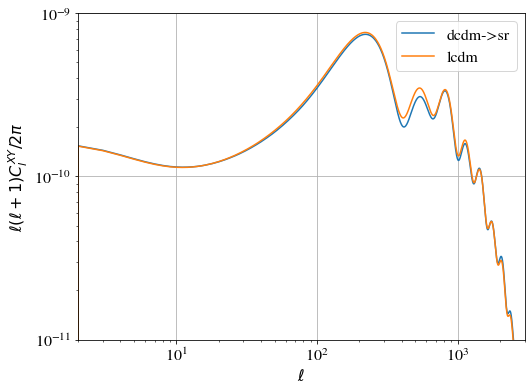

In [8]:
l = cls['ell']
plt.plot(cls['ell'],l*(l+1.)/2./np.pi*cls['tt'],label='dcdm->sr')
l = cls_lcdm['ell']
plt.plot(cls_lcdm['ell'],l*(l+1.)/2./np.pi*cls_lcdm['tt'],label='lcdm')
plt.loglog()
plt.legend()
plt.xlim([2,3000])
plt.ylim([1.e-11,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()

In [17]:
M_dr_is_sr.Omega_Lambda()

0.7209980846229376

In [12]:
M_lcdm.struct_cleanup()
M_lcdm.empty()

M_dr_is_sr.struct_cleanup()
M_dr_is_sr.empty()

In [10]:
M_dr_is_sr.h()

0.762954

In [11]:
M_lcdm.h()

0.6842609

In [10]:
M_dr_is_sr.T_cmb()

2.6

In [13]:
T_cmb_eff

array([2.2       , 2.2       , 2.2       , ..., 2.6011925 , 2.60536971,
       2.60820345])

In [6]:

Omega_dm_tot = 0.25
f_dm_decay = 0.01
Gamma_dcdm = 2000.

common_settings_dcdm_syn = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
    'k_output_values' : k_list
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}

common_settings_dcdm_new = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                   '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
#                    'A_s':2.215e-9,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'new',
    'k_output_values' : k_list,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246}
                   # other output and precision parameters
                   #'l_max_scalars':3000}


common_settings_dcdm_syn_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.5
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_dcdm_syn_dr_is_sr_test = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'synchronous',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    'perturb_integration_stepsize': 0.05, # default 0.5
    'perturb_sampling_stepsize': 0.01, #default 0.1
    'tol_perturb_integration': 1e-6,#default 1e-5
    'tight_coupling_trigger_tau_c_over_tau_k': 0.001 # default 0.01
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_dcdm_new_dr_is_sr = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                    '100*theta_s':1.04119,
                   'omega_b':0.022032,
                   'Omega_dm_tot': Omega_dm_tot,
                   'f_dm_decay': f_dm_decay,
                    'Gamma_dcdm':Gamma_dcdm,
                    'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
                    'gauge' : 'newtonian',
                    'dr_is_sr': 1,
    'k_output_values' : k_list,
    #'perturb_integration_stepsize': 0.05
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
#    'root': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_T0/output/test_dr_sr',
#    'write parameters': 'yes'
}


common_settings_lcdm = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                '100*theta_s':1.04119,
                   'omega_b':0.022032,
 'Omega_cdm':Omega_dm_tot,
                    #'Gamma_dcdm':0.,
                   'ln10^{10}A_s' : 3.0980,
                   'tau_reio':0.0925,
    'k_output_values' : k_list
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
#                   'YHe':0.246
}

In [7]:
M_lcdm = Class()
M_lcdm.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_lcdm.compute()



M_dr = Class()
M_dr.set(common_settings_dcdm_syn)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr.compute()


M_dr_is_sr = Class()
M_dr_is_sr.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr.compute()

M_dr_is_sr_test = Class()
M_dr_is_sr_test.set(common_settings_dcdm_syn_dr_is_sr_test)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr_test.compute()


M_dr_is_sr_new = Class()
M_dr_is_sr_new.set(common_settings_dcdm_new_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M_dr_is_sr_new.compute()

0, 0: 100*theta_s 1.041e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 1.803e+07 Omega_dr = 1.803e+07
omega_dcdmdr = 1.79751036e+07
T_cmb_dcdmsr = 3.98935209e-312
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 2.035e+07 Omega_dr = 2.035e+07
omega_dcdmdr = 1.79751036e+07
T_cmb_dcdmsr = 3.98935209e-312
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.267e-05 Omega_dr = 1.914e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.282e-05 Omega_dr = 1.920e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00
pba->Omega0_cdm = 2.50000000e-01
Omega_dcdm = 5.437e-05 Omega_dr = 1.976e+07
omega_dcdmdr = 8.98755179e+06
T_cmb_dcdmsr = 0.00000000e+00
pba->Omega0_dcdmdr = 0.00000000e+00


In [6]:
_Mpc_over_m_ = 3.085677581282e22
_PI_ = 3.1415926535897932384626433832795e0
_c_ = 2.99792458e8 
_G_ = 6.67428e-11
_k_B_ = 1.3806504e-23
_h_P_ = 6.62606896e-34
T_cmb = M_lcdm.T_cmb()
h = M_lcdm.h()
H0_class = h*100*1e3/_c_
rho_crit0_class = H0_class**2
sigma_B = 2. * np.power(_PI_,5) * np.power(_k_B_,4) / 15. / np.power(_h_P_,3) / np.power(_c_,2)
Omega0_g_lcdm = (4.*sigma_B/_c_*np.power(T_cmb,4.)) / (3.*_c_*_c_*1.e10*h*h/_Mpc_over_m_/_Mpc_over_m_/8./_PI_/_G_)

In [10]:
M_dr_is_sr.get_background()['z']

array([1.00000000e+14, 9.93048659e+13, 9.86145640e+13, ...,
       1.36916594e-02, 6.60715603e-03, 0.00000000e+00])

Text(0, 0.5, '$\\Omega(z)$')

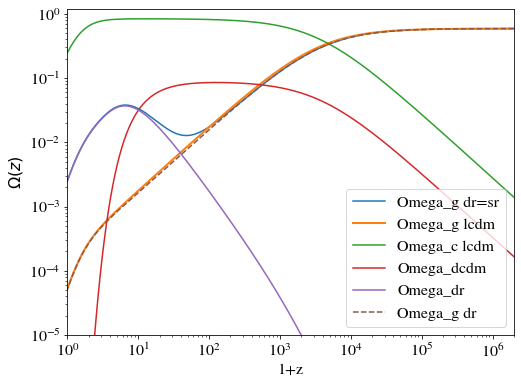

In [12]:
plt.loglog(1.+M_dr_is_sr.get_background()['z'],M_dr_is_sr.get_background()['(.)rho_g']/M_dr_is_sr.get_background()['(.)rho_crit'],
           label='Omega_g dr=sr')


plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_g']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_g lcdm',lw=2)
plt.loglog(1.+M_lcdm.get_background()['z'],M_lcdm.get_background()['(.)rho_cdm']/M_lcdm.get_background()['(.)rho_crit'],label='Omega_c lcdm')



# plt.loglog(1.+M_lcdm.get_background()['z'],Omega0_g_lcdm*(1.+M_lcdm.get_background()['z']))

plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'],label='Omega_dcdm')
plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'],label='Omega_dr')
plt.loglog(1.+M_dr.get_background()['z'],M_dr.get_background()['(.)rho_g']/M_dr.get_background()['(.)rho_crit'],ls='--',label='Omega_g dr')


plt.legend(loc=4)
plt.xlim(1e0,2.e6)
plt.ylim(1e-5,1.2)
plt.xlabel('1+z')
plt.ylabel(r'$\Omega(z)$')

In [18]:
Om_dr = (M_dr.get_background()['(.)rho_dr']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_dcdm = (M_dr.get_background()['(.)rho_dcdm']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_cdm = (M_dr.get_background()['(.)rho_cdm']/M_dr.get_background()['(.)rho_crit'])[-1]
Om_dcdm+Om_dr

0.002500252107575085

In [21]:
Om_dr = (M_dr_is_sr.get_background()['(.)rho_dr']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_dcdm = (M_dr_is_sr.get_background()['(.)rho_dcdm']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_cdm = (M_dr_is_sr.get_background()['(.)rho_cdm']/M_dr_is_sr.get_background()['(.)rho_crit'])[-1]
Om_dcdm+Om_dr

0.0025002513397718285

In [22]:
Om_cdm

0.24749993763750025

In [20]:
Om_dr

0.0025002521075515767

Text(0, 0.5, '(.)$\\rho_g(z)$')

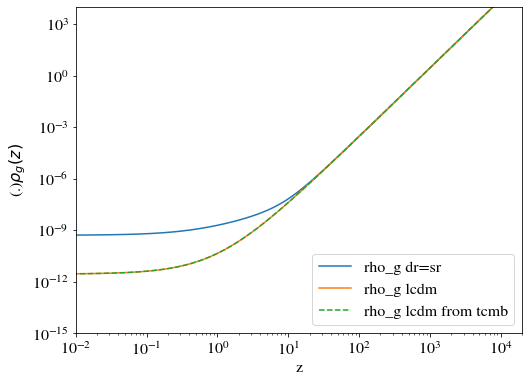

In [9]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
plt.loglog(z,rho_g,
           label='rho_g dr=sr')

z = M_lcdm.get_background()['z']
rho_g_lcdm = M_lcdm.get_background()['(.)rho_g']
plt.loglog(z,rho_g_lcdm,
           label='rho_g lcdm')

rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
plt.loglog(z,rho_g_lcdm,
           ls = '--',
           label='rho_g lcdm from tcmb')




plt.legend(loc=4)
plt.xlim(1e-2,2e4)
plt.ylim(1e-15,1e4)
plt.xlabel('z')
plt.ylabel(r'(.)$\rho_g(z)$')

Text(0, 0.5, '$T_{cmb}(z)$')

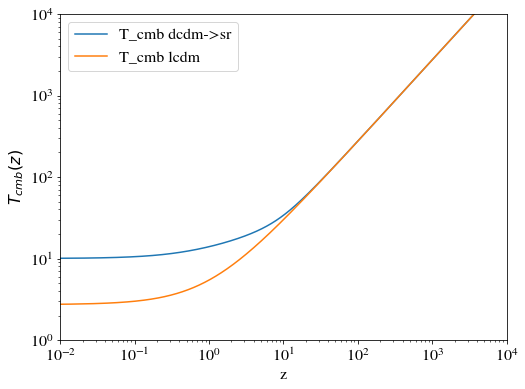

In [10]:
z = M_dr_is_sr.get_background()['z']
rho_g = M_dr_is_sr.get_background()['(.)rho_g']
rho_g_lcdm = Omega0_g_lcdm*(1.+z)**4.*rho_crit0_class
T_cmb_eff = T_cmb*(rho_g/rho_g_lcdm)**0.25
plt.plot(z,T_cmb_eff*(1.+z),
           label='T_cmb dcdm->sr')
plt.plot(z,T_cmb*(1.+z),
           label='T_cmb lcdm')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e4)
plt.ylim(1e0,1e4)
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$T_{cmb}(z)$')

In [248]:
T_cmb_eff

array([ 2.7255    ,  2.7255    ,  2.7255    , ...,  9.96389165,
        9.99606626, 10.02661518])

In [ ]:
#   /** - compute expansion rate H from Friedmann equation: this is the
#       only place where the Friedmann equation is assumed. Remember
#       that densities are all expressed in units of \f$ [3c^2/8\pi G] \f$, ie
#       \f$ \rho_{class} = [8 \pi G \rho_{physical} / 3 c^2]\f$ */

In [130]:
M_dr.get_transfer().keys()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_dcdm', 'd_dr', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_ur', 't_dcdm', 't_dr', 't_tot'])

Text(0, 0.5, '$\\delta_g^2$')

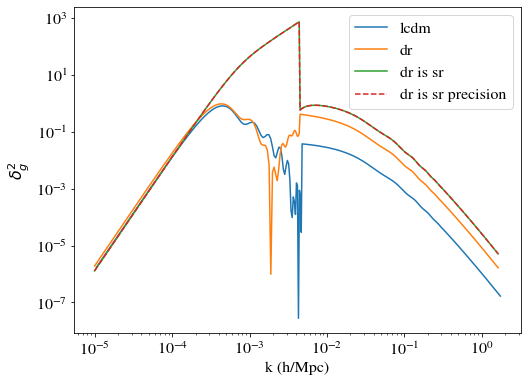

In [131]:
plt.plot(M_lcdm.get_transfer()['k (h/Mpc)'],M_lcdm.get_transfer()['d_g']**2.,label='lcdm')
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['d_g']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['d_g']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['d_g']**2.,ls='--',label='dr is sr precision')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\delta_g^2$')

In [132]:
M_lcdm.get_transfer().keys()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_ur', 't_tot'])

Text(0, 0.5, '$\\theta_g^2$')

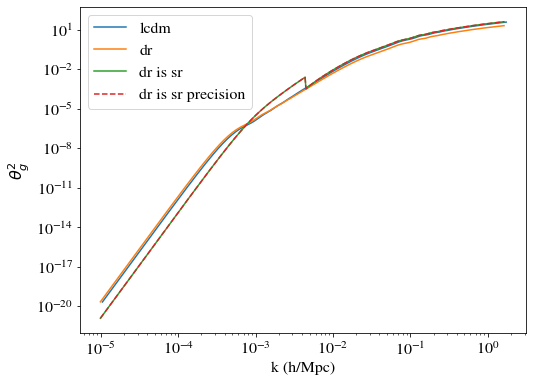

In [133]:
plt.plot(M_lcdm.get_transfer()['k (h/Mpc)'],M_lcdm.get_transfer()['t_g']**2.,label='lcdm')
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['t_g']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['t_g']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['t_g']**2.,ls='--',label='dr is sr precision')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\theta_g^2$')

Text(0, 0.5, '$\\theta_g^2$')

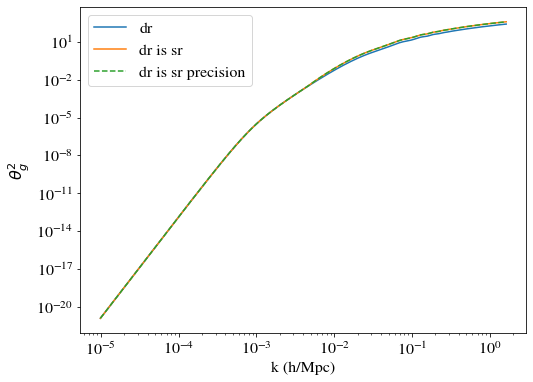

In [144]:
plt.plot(M_dr.get_transfer()['k (h/Mpc)'],M_dr.get_transfer()['t_dr']**2.,label='dr')
plt.plot(M_dr_is_sr.get_transfer()['k (h/Mpc)'],M_dr_is_sr.get_transfer()['t_dr']**2.,label='dr is sr')
plt.plot(M_dr_is_sr_test.get_transfer()['k (h/Mpc)'],M_dr_is_sr_test.get_transfer()['t_dr']**2.,ls='--',label='dr is sr precision')
plt.ylim
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$\theta_g^2$')


In [47]:
M_dr.get_perturbations()['scalar'][0].keys()

dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_dcdm', 'theta_dcdm', 'delta_dr', 'theta_dr', 'shear_dr'])

Text(0.5, 1.0, 'k=1.000e-02 h/Mpc')

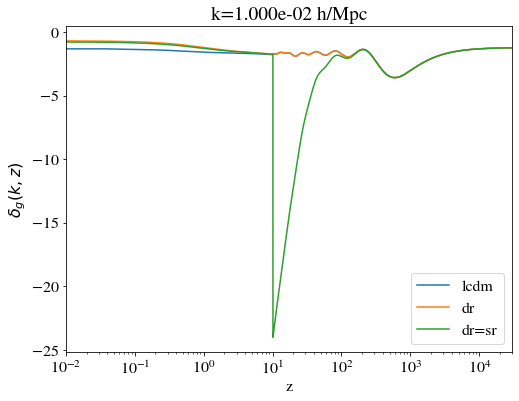

In [143]:
i = 2
k = k_list_d[i]

z = 1./M_lcdm.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_lcdm.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='lcdm')


z = 1./M_dr.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_dr.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='dr')


z = 1./M_dr_is_sr.get_perturbations()['scalar'][i]['a']-1.
delta_g = M_dr_is_sr.get_perturbations()['scalar'][i]['delta_g']
plt.plot(z,delta_g,label='dr=sr')


plt.xlim(1.e-2,30000)
plt.xscale('log')
plt.legend(loc=4)
plt.xlabel('z')
plt.ylabel(r'$\delta_g (k,z)$')
plt.title('k=%.3e h/Mpc'%k)

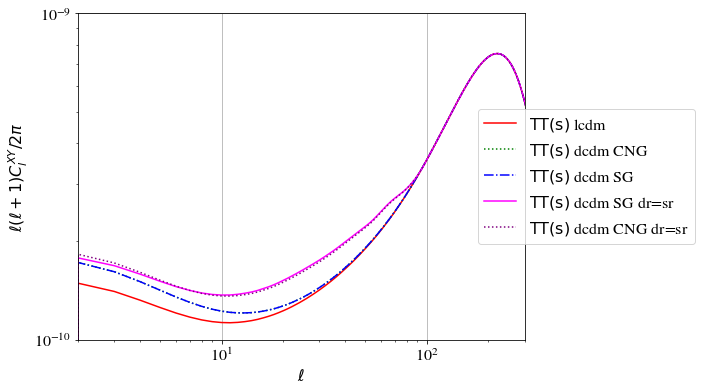

In [28]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#



                   # other output and precision parameters
                   #'l_max_scalars':3000}
###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings_dcdm_new)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_new = M.raw_cl(2500)
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings_dcdm_syn)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_syn = M.raw_cl(2500)
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings_dcdm_syn_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_syn_dr_is_sr = M.raw_cl(2500)
M.struct_cleanup()
M.empty()



M = Class()
M.set(common_settings_dcdm_new_dr_is_sr)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_dcdm_new_dr_is_sr = M.raw_cl(2500)
M.struct_cleanup()
M.empty()




M = Class()
M.set(common_settings_lcdm)
# M.set({'output':'tCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls_lcdm = M.raw_cl(2500)
M.struct_cleanup()
M.empty()

#################
#
# start plotting
#
#################
#
plt.xlim([2,300])
plt.ylim([1.e-10,1e-9])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi $")

plt.grid()
#
ell = cls_lcdm['ell']

factor = ell*(ell+1.)/2./math.pi

#
plt.loglog(ell,factor*cls_lcdm['tt'],'r-',label=r'$\mathrm{TT(s)}$ lcdm')
plt.loglog(ell,factor*cls_dcdm_new['tt'],'g:',label=r'$\mathrm{TT(s)}$ dcdm CNG')
plt.loglog(ell,factor*cls_dcdm_syn['tt'],'b-.',label=r'$\mathrm{TT(s)}$ dcdm SG')
plt.loglog(ell,factor*cls_dcdm_syn_dr_is_sr['tt'],'magenta',label=r'$\mathrm{TT(s)}$ dcdm SG dr=sr')
plt.loglog(ell,factor*cls_dcdm_new_dr_is_sr['tt'],c='purple',ls=':',label=r'$\mathrm{TT(s)}$ dcdm CNG dr=sr')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

In [ ]:
plt.savefig('cl_ST.pdf',bbox_inches='tight')

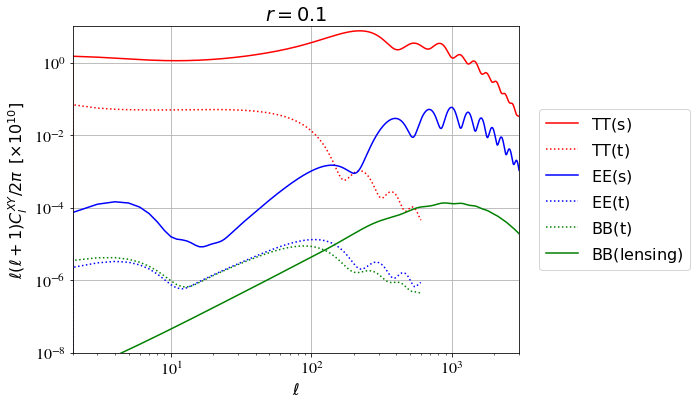

In [3]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246}
                   # other output and precision parameters
                   #'l_max_scalars':3000}
###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':3000})
M.compute()
cls = M.raw_cl(3000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
# for l_max=600 we can keep default precision
# for l_max = 3000 we would need to import many high precision settings from the file cl_ref.pre
#M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':3000})
#M.set({
#'recfast_Nz0':100000,
#'tol_thermo_integration':1.e-5,
#'recfast_x_He0_trigger_delta':0.01,
#'recfast_x_H0_trigger_delta':0.01,
#'evolver':0,
#'k_min_tau0':0.002,
#'k_max_tau0_over_l_max':3.,
#'k_step_sub':0.015,
#'k_step_super':0.0001,
#'k_step_super_reduction':0.1,
#'start_small_k_at_tau_c_over_tau_h':0.0004,
#'start_large_k_at_tau_h_over_tau_k':0.05,
#'tight_coupling_trigger_tau_c_over_tau_h':0.005,
#'tight_coupling_trigger_tau_c_over_tau_k':0.008,
#'start_sources_at_tau_c_over_tau_h':0.006,
#'l_max_g':50,
#'l_max_pol_g':25,
#'l_max_ur':50,
#'tol_perturb_integration':1.e-6,
#'perturb_sampling_stepsize':0.01,
#'radiation_streaming_approximation':2,
#'radiation_streaming_trigger_tau_over_tau_k':240.,
#'radiation_streaming_trigger_tau_c_over_tau':100.,
#'ur_fluid_approximation':2,
#'ur_fluid_trigger_tau_over_tau_k':50.,
#'l_logstep':1.026,
#'l_linstep':25,
#'hyper_sampling_flat':12.,
#'hyper_nu_sampling_step':10.,
#'hyper_phi_min_abs':1.e-10,
#'hyper_x_tol':1.e-4,
#'hyper_flat_approximation_nu':1.e6,
#'q_linstep':0.20,
#'q_logstep_spline':20.,
#'q_logstep_trapzd':0.5,
#'q_numstep_transition':250,
#'transfer_neglect_delta_k_T_t2':100.,
#'transfer_neglect_delta_k_T_e':100.,
#'transfer_neglect_delta_k_T_b':100.,
#'neglect_CMB_sources_below_visibility':1.e-30,
#'transfer_neglect_late_source':3000.
#})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':3000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(3000)
cl_lensed = M.lensed_cl(3000)
M.struct_cleanup()
M.empty()
#
#################
#
# start plotting
#
#################
#
plt.xlim([2,3000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))